<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lectura" data-toc-modified-id="Lectura-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lectura</a></span></li><li><span><a href="#Limpiado" data-toc-modified-id="Limpiado-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Limpiado</a></span><ul class="toc-item"><li><span><a href="#Modified-Z-score" data-toc-modified-id="Modified-Z-score-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Modified Z-score</a></span></li></ul></li><li><span><a href="#Normalización" data-toc-modified-id="Normalización-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Normalización</a></span><ul class="toc-item"><li><span><a href="#Ajuste-de-polinomio" data-toc-modified-id="Ajuste-de-polinomio-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Ajuste de polinomio</a></span></li><li><span><a href="#AFS" data-toc-modified-id="AFS-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>AFS</a></span></li><li><span><a href="#Visualización-+-guardado" data-toc-modified-id="Visualización-+-guardado-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Visualización + guardado</a></span></li></ul></li><li><span><a href="#Unión-de-órdenes" data-toc-modified-id="Unión-de-órdenes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Unión de órdenes</a></span><ul class="toc-item"><li><span><a href="#Unión-de-las-long-de-onda" data-toc-modified-id="Unión-de-las-long-de-onda-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Unión de las long de onda</a></span></li><li><span><a href="#Unión-de-los-flujos" data-toc-modified-id="Unión-de-los-flujos-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Unión de los flujos</a></span></li></ul></li><li><span><a href="#Save" data-toc-modified-id="Save-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save</a></span></li></ul></div>

# Normalización y Unión de los órdenes

La notebook lee un espectro reducido y tiene una sección para normalizar los órdenes y una sección para hacer el merger de los órdenes. Al final se guarda el espectro mergeado con las keywords agregadas en el header.

- Primero cargo paquetes y cosas necesarias

In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [87]:
import pyspeckit
import astropy.io.fits as pf
import matplotlib.pyplot as plt 
import numpy as np  
import pandas as pd
import glob
import os
import astropy.units as u

from specutils import Spectrum1D
from specutils.manipulation import LinearInterpolatedResampler
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy.modeling import models, fitting
from astropy.table import Table
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting
from scipy import interpolate

## Lectura

* Yo voy a usar *pysepckit* para leer porque me reconoce las long de onda directamente (del espectro reducido con iraf).
* Se podría usar *astropy.io.fits* --> mi problema con esto fue que no pude armar el wcs para la long de onda de una manera sencilla para todos los órdenes

In [144]:
slice_speclist = []
speclist = pyspeckit.wrappers.load_IRAF_multispec('0605CASwobj73.fits') #si el espectro tiene más de dos dimensiones hay que primero hacer un scopy y quedarse con la banda que tiene el espectro

for spec in speclist:
    # Definimos las unidades del flujo
    spec.unit="Counts"
    # Arreglamos el header para que sea fits standard
    hdu = pf.PrimaryHDU(None, spec.header) #lo tenemos que pasar a objeto HDUlist para que funcione el verify
    hdu.verify('fix')
    spec.header = hdu.header
    # Corto en cada orden los bordes: un 15% del lado azul y un 10% del lado rojo 
    slice_speclist.append(spec.slice(154,922,unit='pixel')) # estos números son para ordenes de CASLEO

non-ASCII characters are present in the FITS file header and have been replaced by "?" characters
Verification reported errors:
Card 9:
    Card 'UT' is not FITS standard (invalid value string: '06:41:35               / universal time').  Fixed 'UT' card to meet the FITS standard.
Card 10:
    Card 'ST' is not FITS standard (invalid value string: '17:34:28               / sidereal time').  Fixed 'ST' card to meet the FITS standard.
Card 11:
    Card 'HA' is not FITS standard (invalid value string: '-00:32:04              / hour angle').  Fixed 'HA' card to meet the FITS standard.
Card 12:
    Card 'RA' is not FITS standard (invalid value string: '18:06:32               / right ascension').  Fixed 'RA' card to meet the FITS standard.
Card 13:
    Card 'DEC' is not FITS standard (invalid value string: '-24:12:06              / declination').  Fixed 'DEC' card to meet the FITS standard.
Note: astropy.io.fits uses zero-based indexing.

Verification reported errors:
Card 9:
    Card 'UT' is

Verification reported errors:
Card 9:
    Card 'UT' is not FITS standard (invalid value string: '06:41:35               / universal time').  Fixed 'UT' card to meet the FITS standard.
Card 10:
    Card 'ST' is not FITS standard (invalid value string: '17:34:28               / sidereal time').  Fixed 'ST' card to meet the FITS standard.
Card 11:
    Card 'HA' is not FITS standard (invalid value string: '-00:32:04              / hour angle').  Fixed 'HA' card to meet the FITS standard.
Card 12:
    Card 'RA' is not FITS standard (invalid value string: '18:06:32               / right ascension').  Fixed 'RA' card to meet the FITS standard.
Card 13:
    Card 'DEC' is not FITS standard (invalid value string: '-24:12:06              / declination').  Fixed 'DEC' card to meet the FITS standard.
Note: astropy.io.fits uses zero-based indexing.

Verification reported errors:
Card 9:
    Card 'UT' is not FITS standard (invalid value string: '06:41:35               / universal time').  Fixed 'UT' 

## Limpiado 

Para limpiar los órdenes voy a usar el *Modified Z-Score* (ver [acá](https://towardsdatascience.com/removing-spikes-from-raman-spectra-8a9fdda0ac22)).

This modified Z-score method uses the median (M) and median absolute deviation (MAD) rather than the mean and standard deviation (la media y desviación estándar se usa para el z-score clásico pero este, en teoría, es más robusto):
$$z(i) = 0.6745 (flux(i)-M) / MAD$$
where the $MAD = median(|flux(i)-M|)$.

Both the median and the MAD are robust measures of the central tendency and dispersion, respectively. The multiplier 0.6745 is the 0.75th quartile of the standard normal distribution, to which the MAD converges to.

We make advantage of the high intensity and small width of spikes and therefore use the difference between consecutive spectrum points $\Delta flux(i) = flux(i)-flux(i-1)$ to calculate the z-scores:
$$z(i) = 0.6745 (\Delta flux(i)-M) / MAD$$
donde ahora MAD es calculado también con $\Delta flux(i)$. 

Entonces, calculamos el array de $\Delta flux$ y a cada una le calculamos su respectivo Z-score modificado. Luego, graficamos los modified Z-score y definimos un threshold a partir del cual estamos seguros que los picos son reales y se pueden remover. Finalmente, removemos los picos definiéndolos como aquellos donde su $|modified Z-score| > threshold$.

### Modified Z-score

Definimos las funciones que vamos a usar

In [8]:
def modified_z_score(flux):
    """Función que define el modified z-score. 
       Variable de entrada:
           flux: tiene todos los $\Delta$ del flujo del espectro (array)
       Devuelve: 
           valor del modified z-score para cada valor de $\Delta$flujo del array de entrada (array) 
    """
    median_flux = np.median(flux)
    mad_flux = np.median([np.abs(flux - median_flux)])
    modified_z_scores = 0.6745 * (flux - median_flux) / mad_flux
    return modified_z_scores

def fixer(flux,m,threshold):
    """ Esta es la función que remueve los picos.
        Variables de entrada: 
            flux: flujo del espectro (array),
            m: valor que determina la cantidad de puntos alrededor del pico que vamos a tomar (int),
            threshold: valor umbral a partir del cual consideramos a un pico como tal (float)
        Devuelve: 
            flujo con los picos removidos (array)
    """
    
    spikes = abs(np.array(modified_z_score(np.diff(flux)))) > threshold
    y_out = flux.copy() # So we don’t overwrite flux 
    for i in np.arange(len(spikes)):
        if spikes[i] != 0: # If we have an spike in position i
            w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
            w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
            #Ajustamos un polinomio en el pedacito del espectro y cambiamos el flujo en esos valores por lo que da el ajuste
            init = models.Linear1D()
            #init = models.Polynomial1D(2, c0=[1, 1], c1=[1, 1], c2=[1, 1], n_models=2)
            fit = fitting.LinearLSQFitter()
            out_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=2.5)
            fitted_spec, mask = out_fit(init, w2, flux[w2])
            #y_out[w2] = np.ma.masked_array(flux[w2], mask=mask)
            y_out[i] = np.median(np.ma.masked_array(flux[w2], mask=mask)) # and we average their values
            
    return y_out

Graficamos los órdenes y su MZS para determinar el threshold a utilizar

<IPython.core.display.Javascript object>


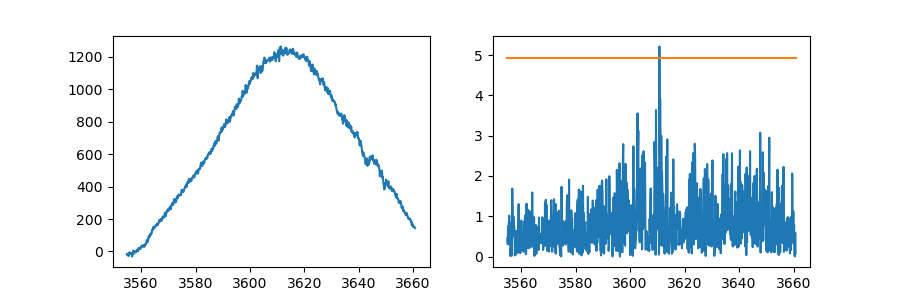

<IPython.core.display.Javascript object>


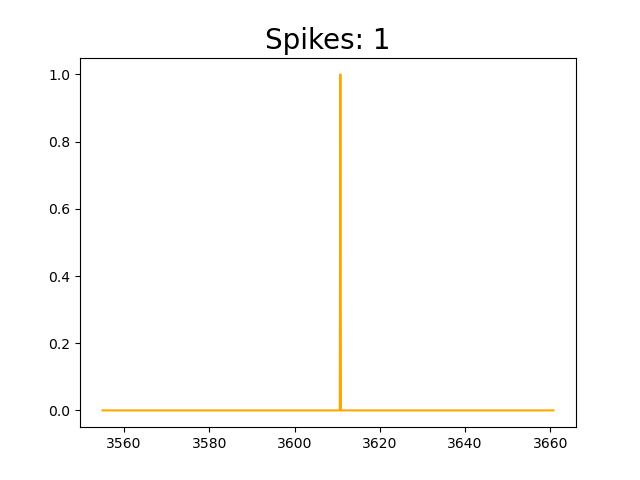

<IPython.core.display.Javascript object>


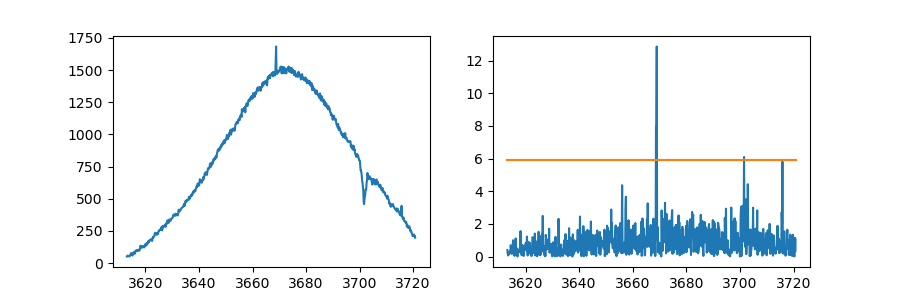

<IPython.core.display.Javascript object>


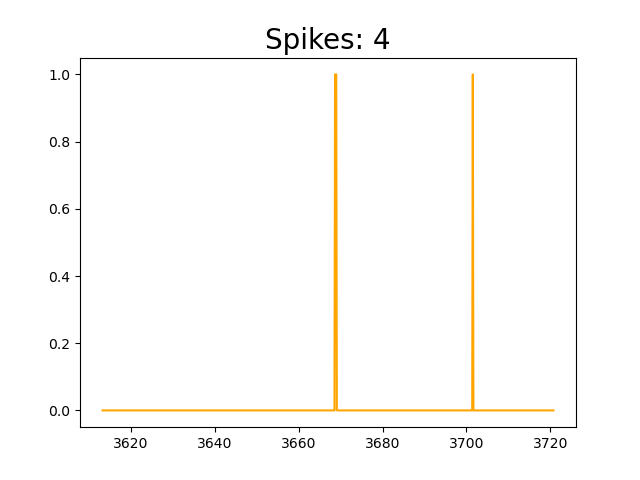

<IPython.core.display.Javascript object>


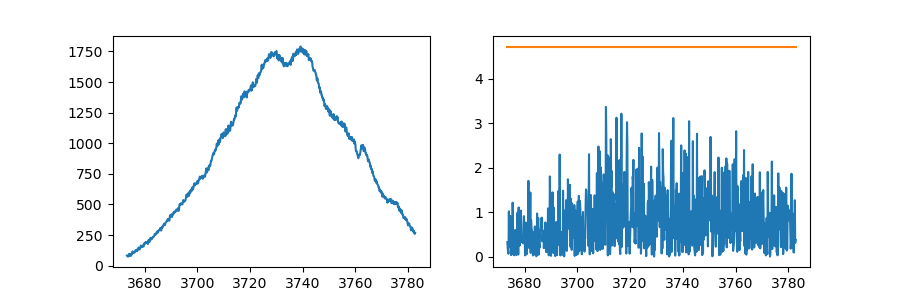

<IPython.core.display.Javascript object>


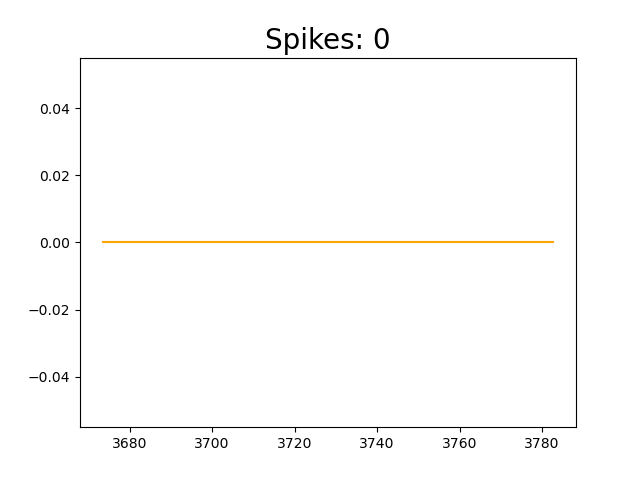

<IPython.core.display.Javascript object>


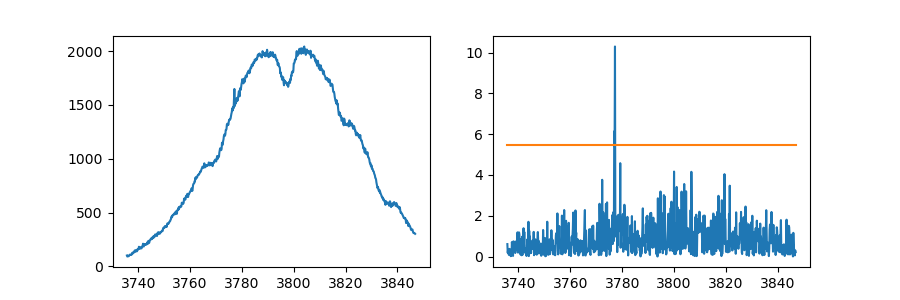

<IPython.core.display.Javascript object>


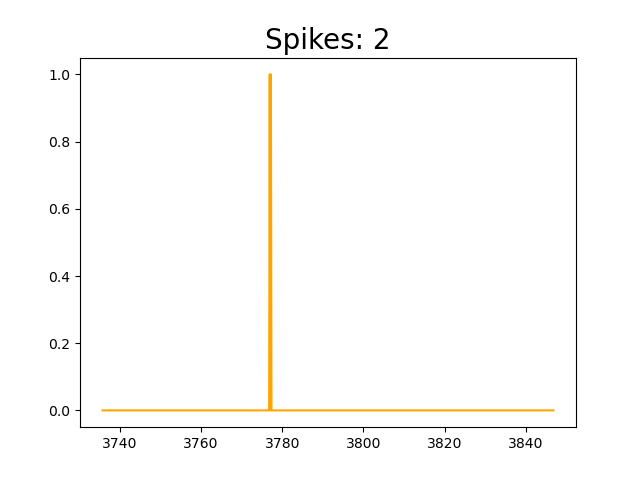

<IPython.core.display.Javascript object>


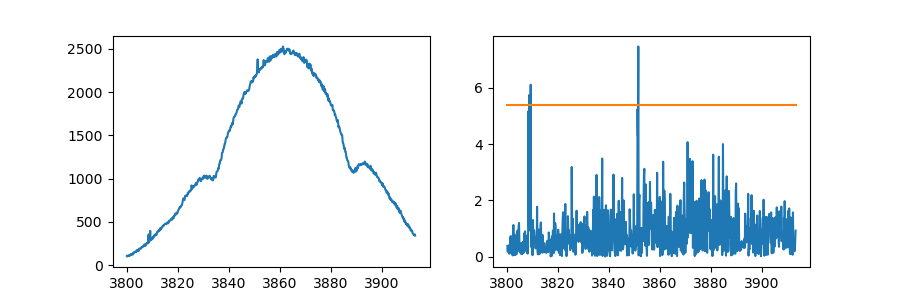

<IPython.core.display.Javascript object>


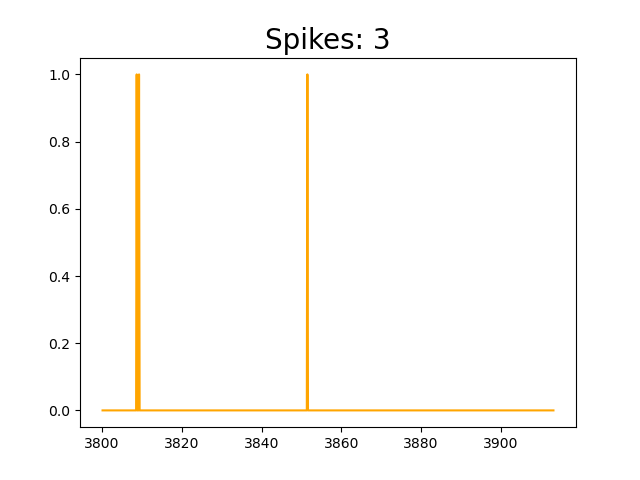

<IPython.core.display.Javascript object>


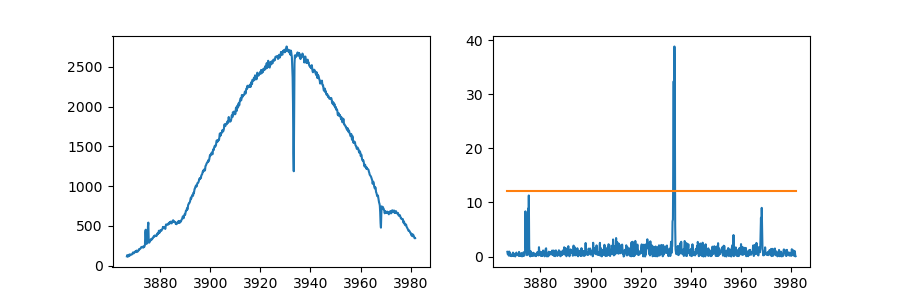

<IPython.core.display.Javascript object>


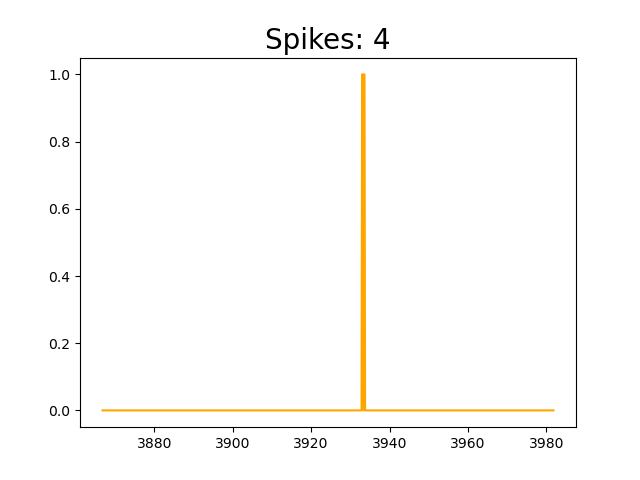

<IPython.core.display.Javascript object>


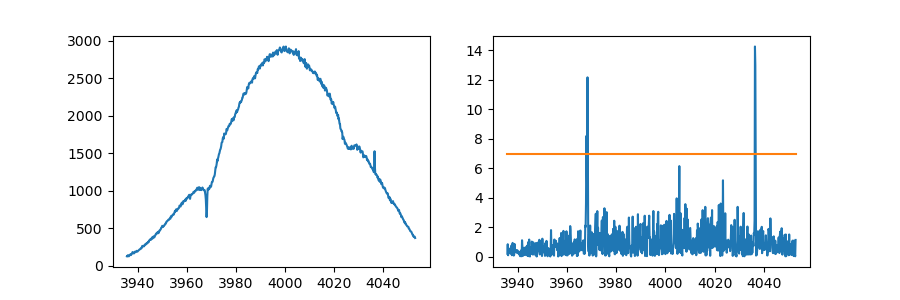

<IPython.core.display.Javascript object>


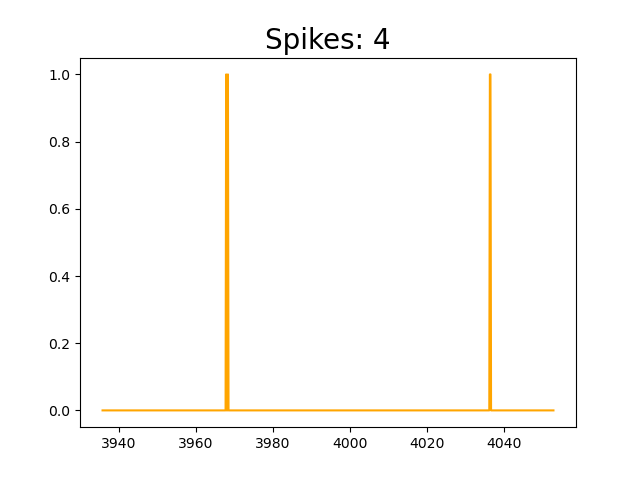

<IPython.core.display.Javascript object>


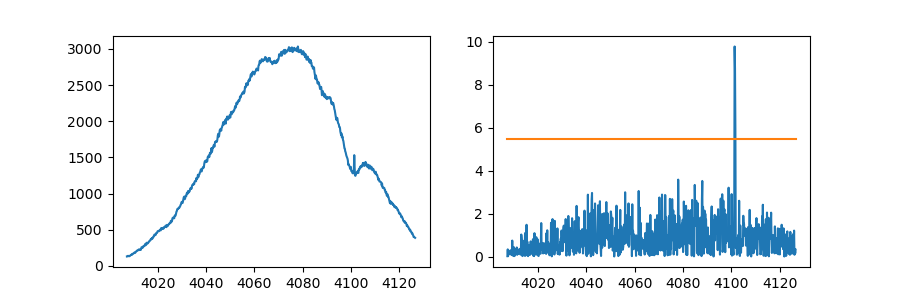

<IPython.core.display.Javascript object>


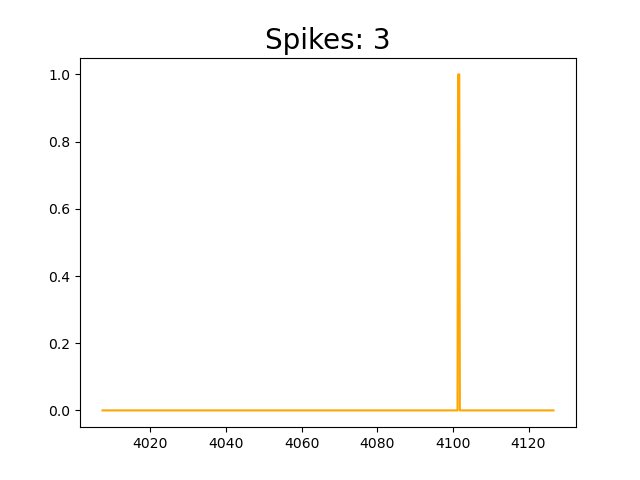

<IPython.core.display.Javascript object>


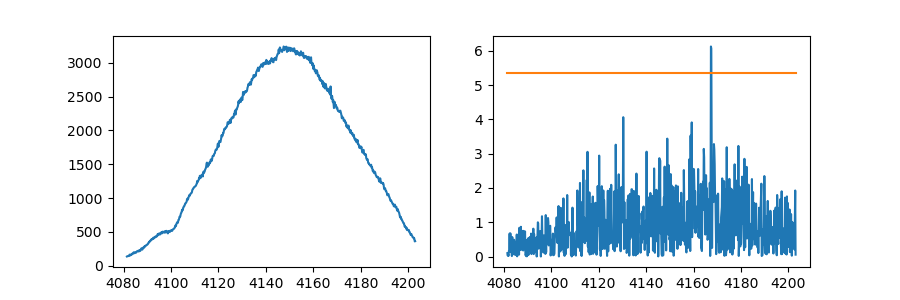

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


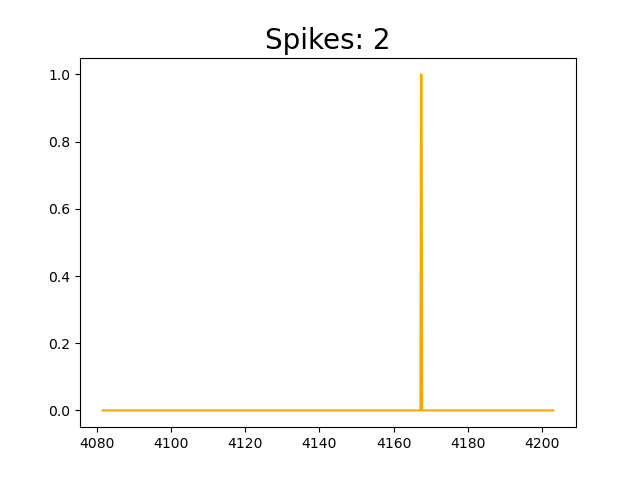

<IPython.core.display.Javascript object>


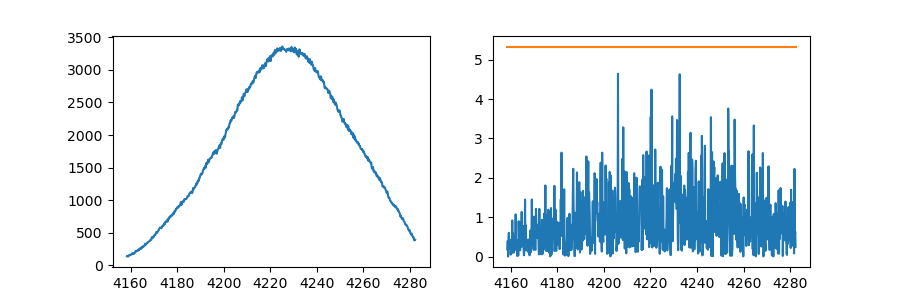

<IPython.core.display.Javascript object>


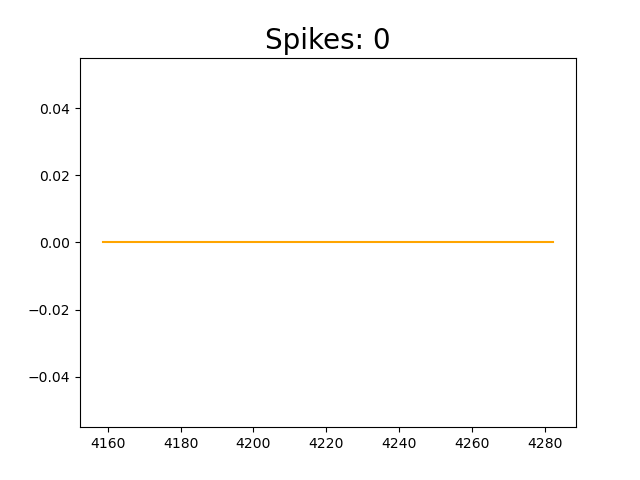

<IPython.core.display.Javascript object>


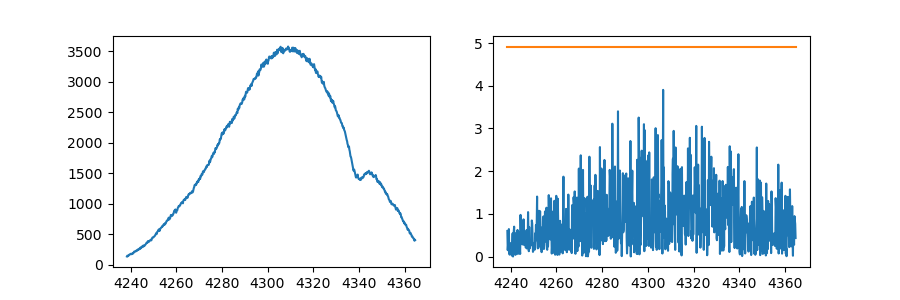

<IPython.core.display.Javascript object>


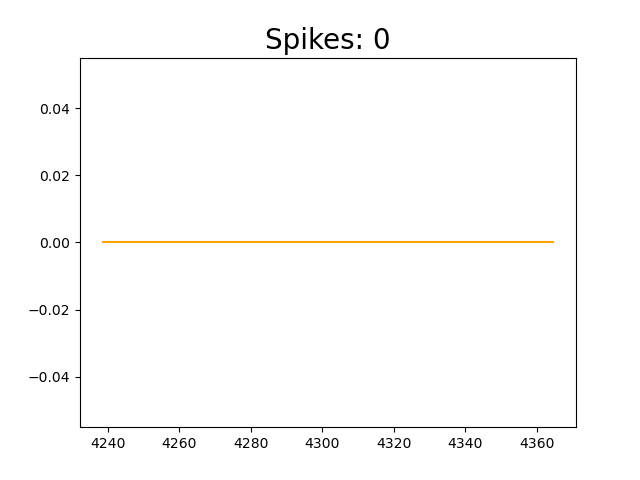

<IPython.core.display.Javascript object>


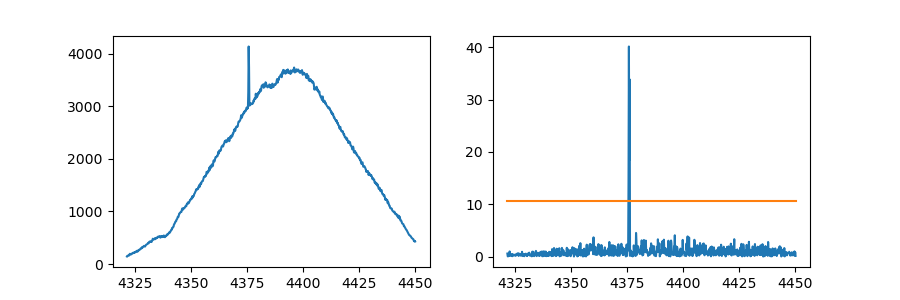

<IPython.core.display.Javascript object>


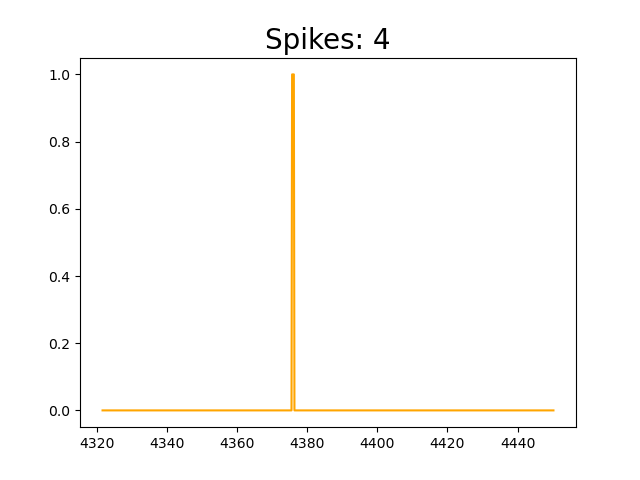

<IPython.core.display.Javascript object>


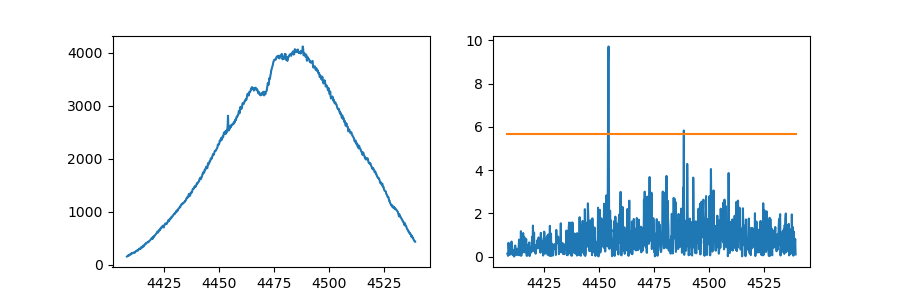

<IPython.core.display.Javascript object>


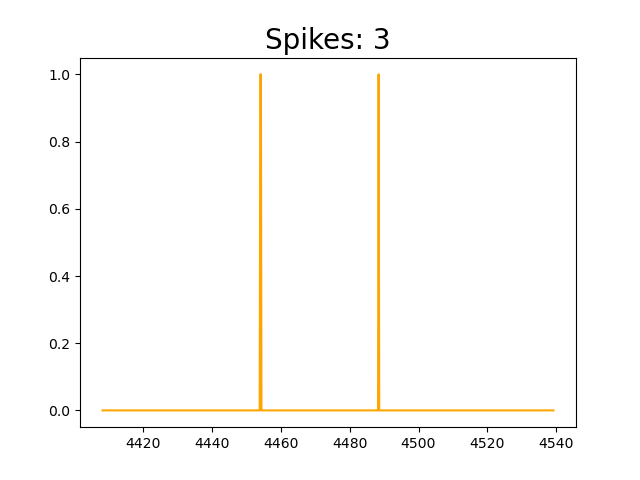

<IPython.core.display.Javascript object>


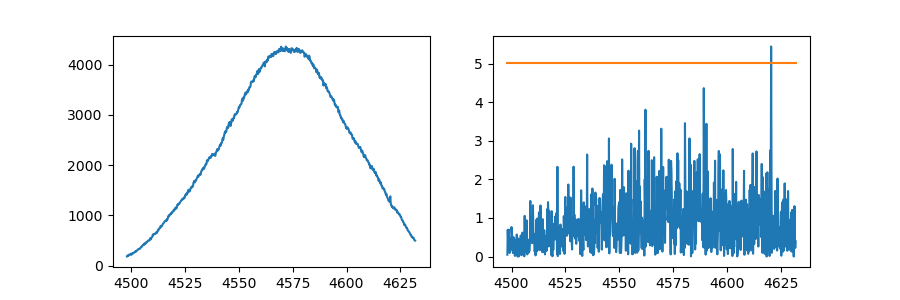

<IPython.core.display.Javascript object>


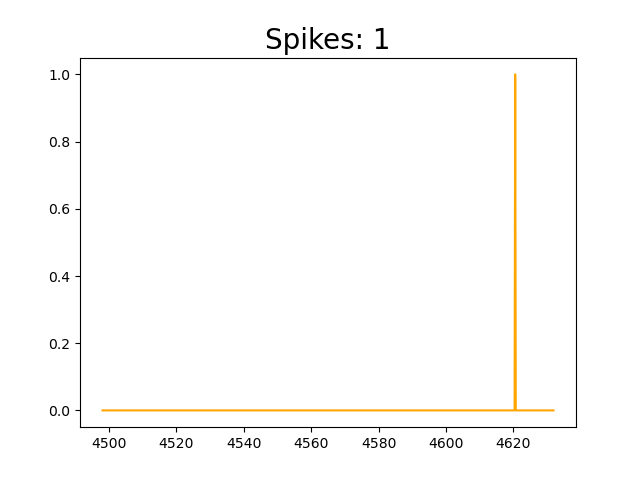

<IPython.core.display.Javascript object>


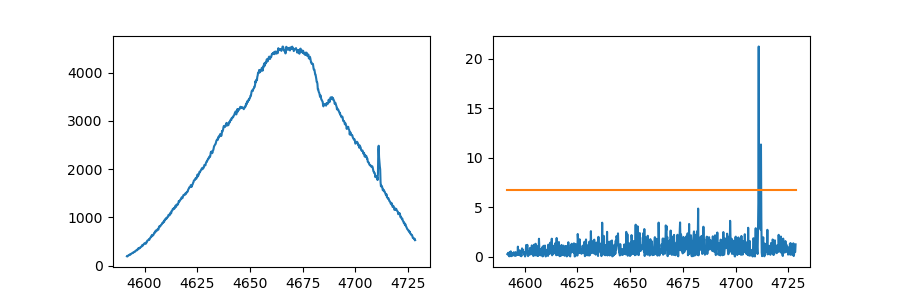

<IPython.core.display.Javascript object>


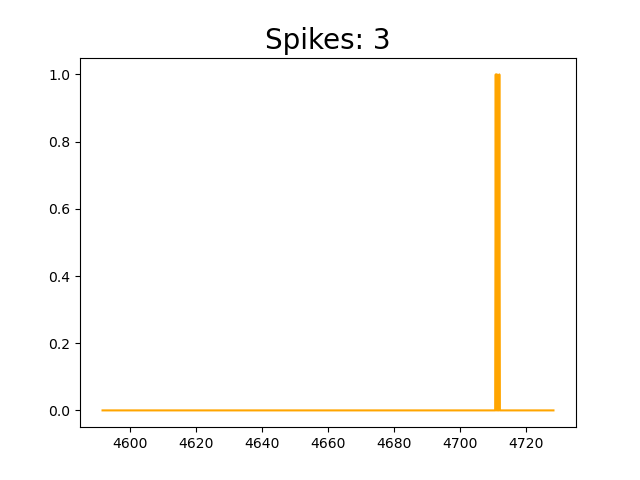

<IPython.core.display.Javascript object>


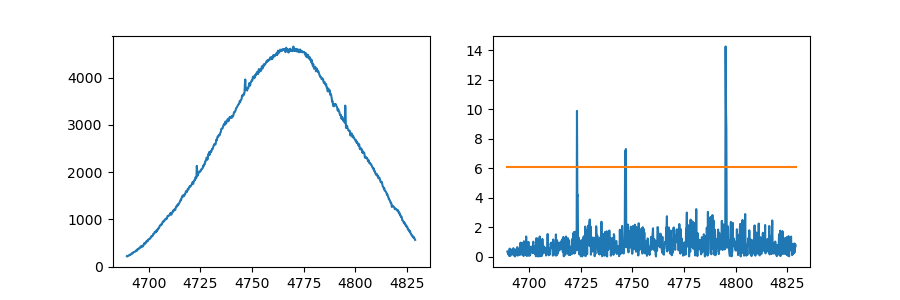

<IPython.core.display.Javascript object>


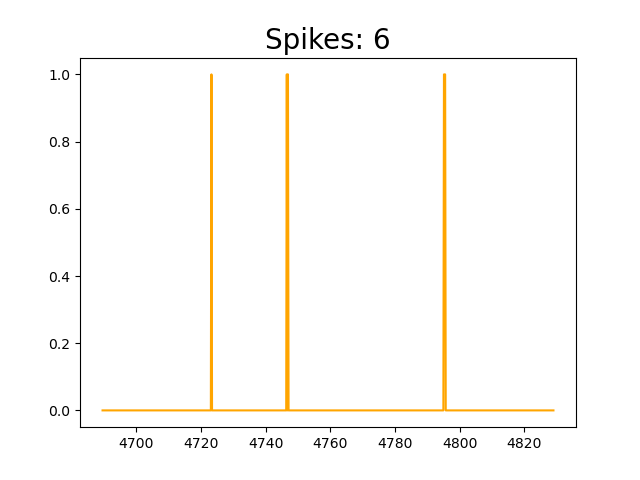

<IPython.core.display.Javascript object>


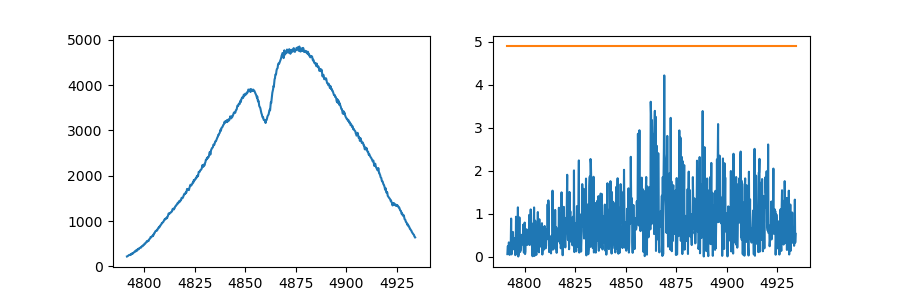

<IPython.core.display.Javascript object>


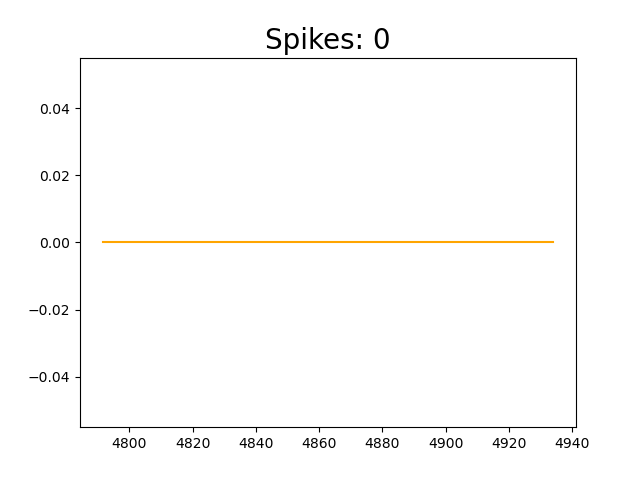

<IPython.core.display.Javascript object>


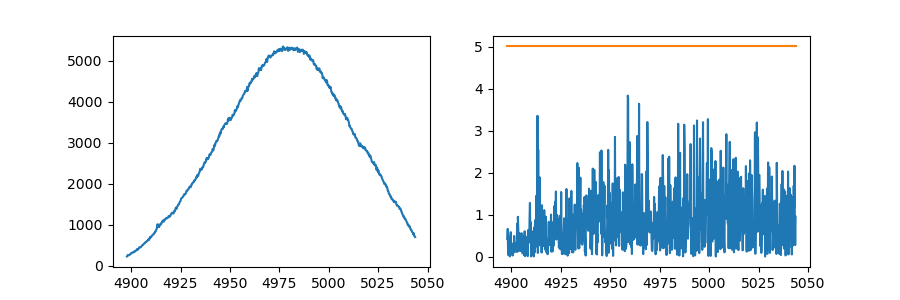

<IPython.core.display.Javascript object>


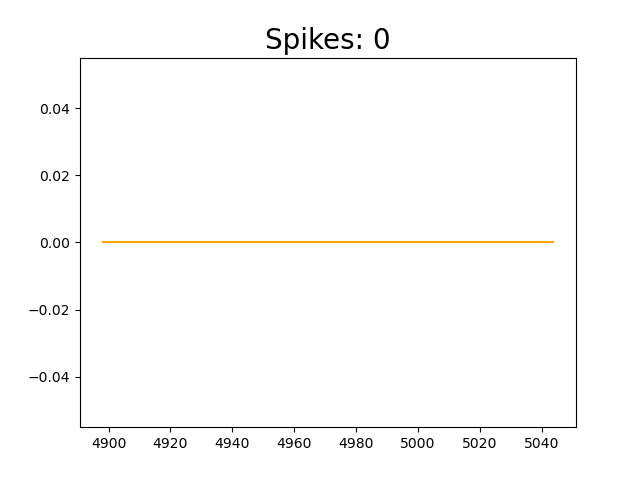

<IPython.core.display.Javascript object>


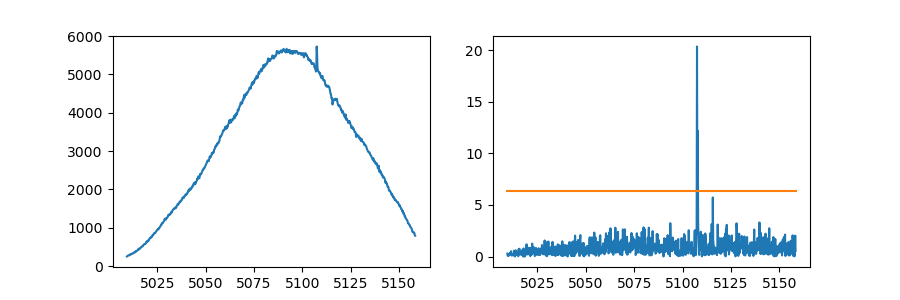

<IPython.core.display.Javascript object>


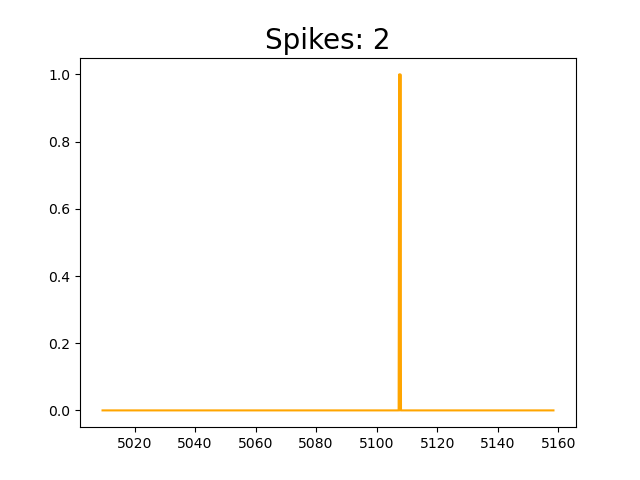

<IPython.core.display.Javascript object>


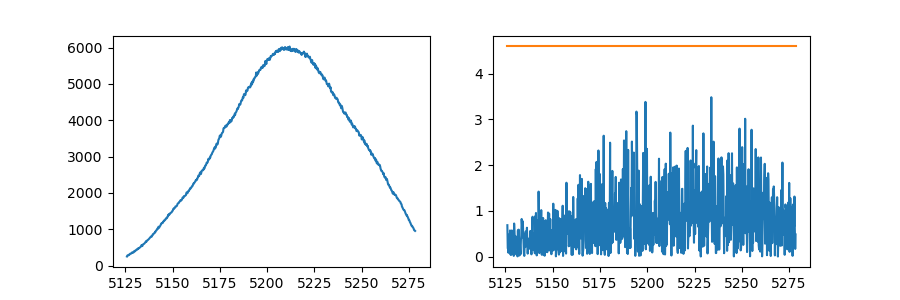

<IPython.core.display.Javascript object>


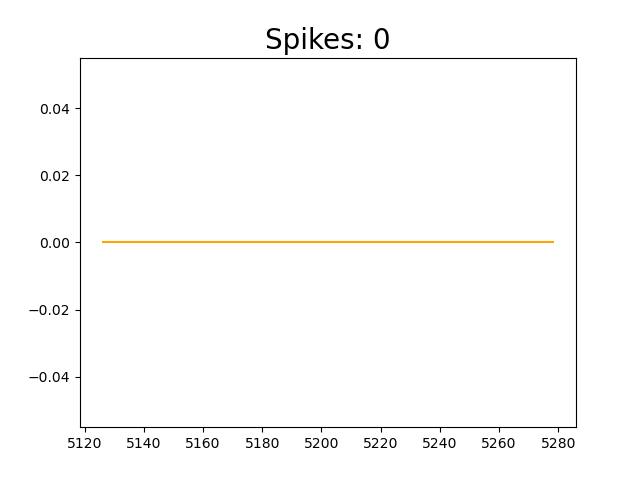

<IPython.core.display.Javascript object>


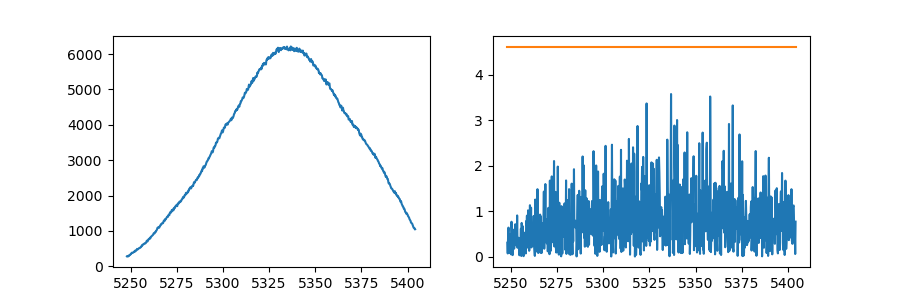

<IPython.core.display.Javascript object>


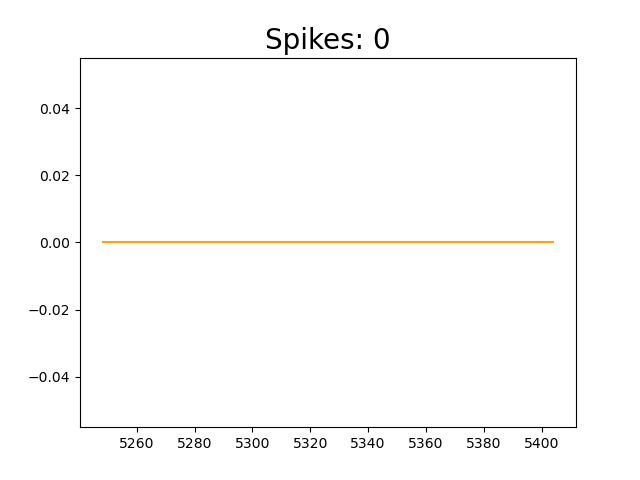

<IPython.core.display.Javascript object>


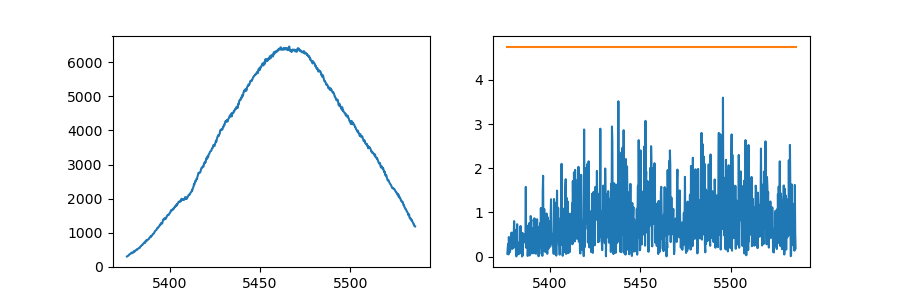

<IPython.core.display.Javascript object>


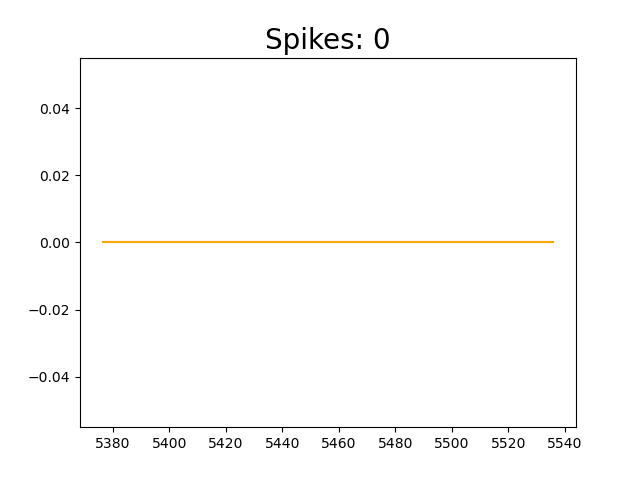

<IPython.core.display.Javascript object>


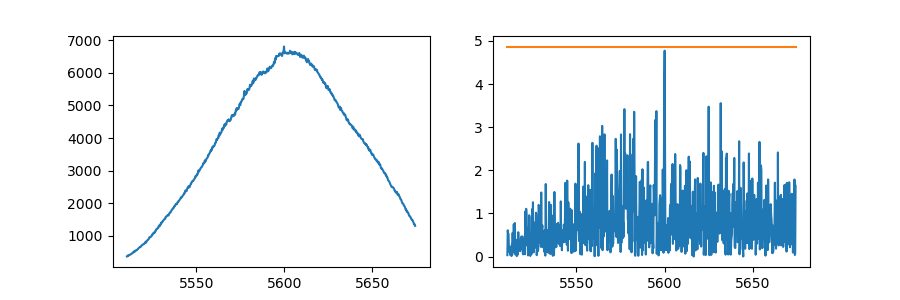

<IPython.core.display.Javascript object>


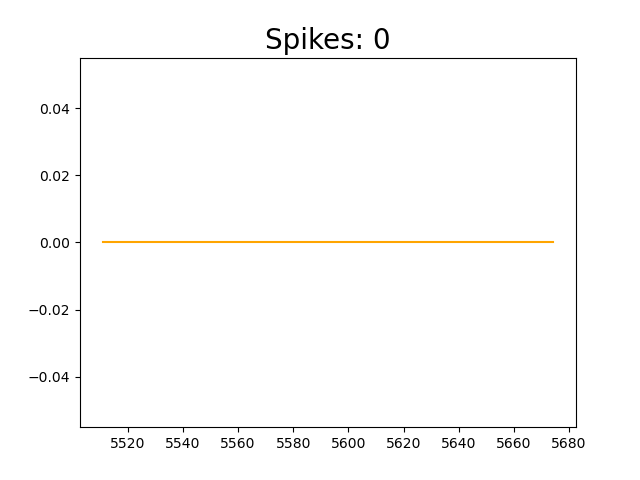

<IPython.core.display.Javascript object>


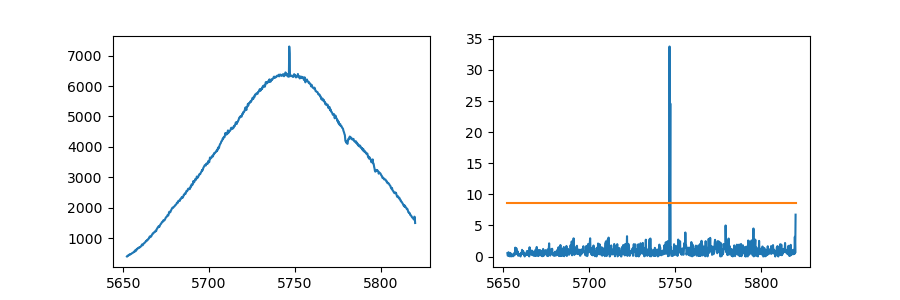

<IPython.core.display.Javascript object>


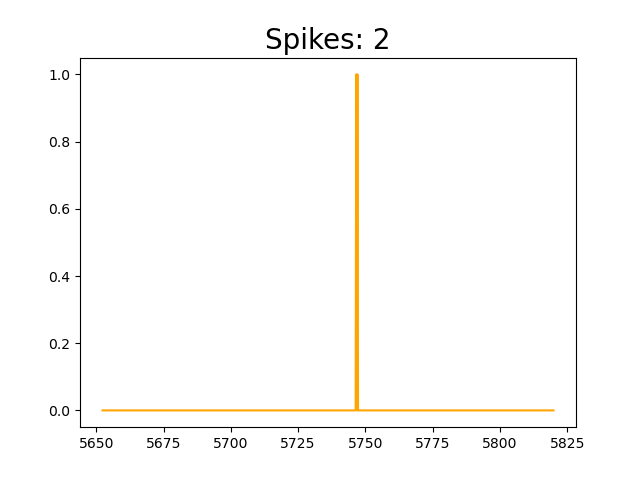

<IPython.core.display.Javascript object>


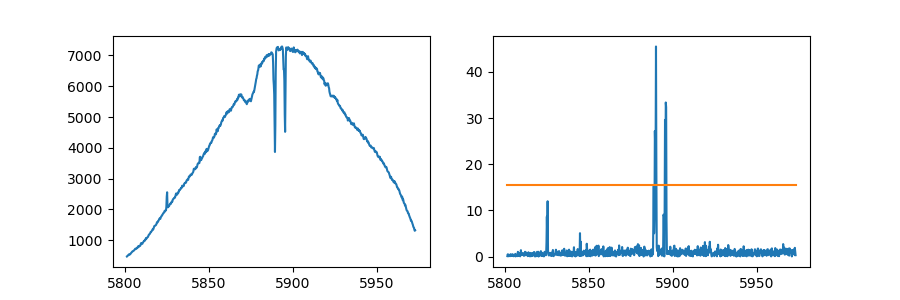

<IPython.core.display.Javascript object>


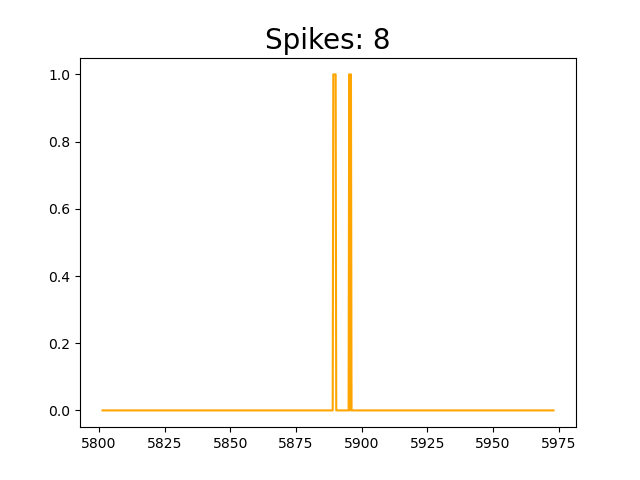

<IPython.core.display.Javascript object>


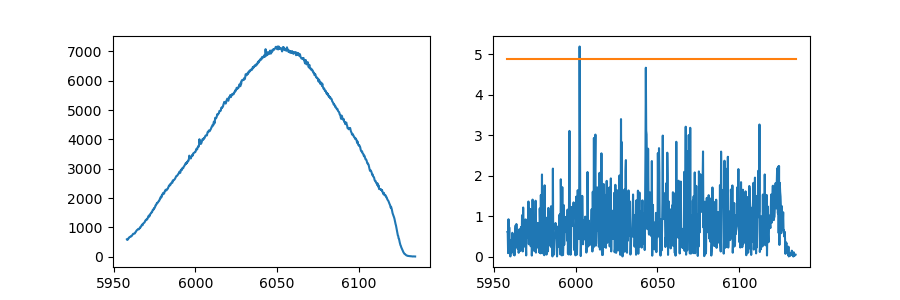

<IPython.core.display.Javascript object>


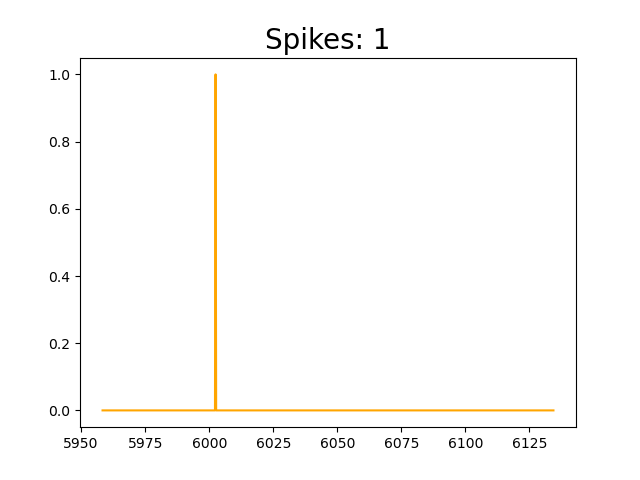

In [34]:
threshold = []
for i in range(len(slice_speclist)):
    dist = 0
    delta_flux = []
    flx = slice_speclist[i].flux #guardo en una variable el flujo corresp al orden que queremos limpiar
    wvl = slice_speclist[i].xarr #lo mismo para long de onda 

    for j in np.arange(len(flx)-1):
        dist = flx[j+1] - flx[j]
        delta_flux.append(dist)
    
    flux_modified_z_score = np.array(modified_z_score(delta_flux)) #calculamos el MZS

    #Definimos un threshold que vamos a usar para eliminar los picos
    th = np.median(flux_modified_z_score) + 4.5*np.std(flux_modified_z_score) #para graficar
    threshold.append(np.median(flux_modified_z_score) + 4.5*np.std(flux_modified_z_score)) #guardamos el threshold para cada orden  

    #Graficamos este modified z-score contra long de onda y chequeamos el threshold que vamos a necesitar
    fig,axs = plt.subplots(1,2,figsize=(9,3))
    #orden
    axs[0].plot(wvl,flx)
    #MDZ score
    axs[1].plot(wvl[1:], abs(flux_modified_z_score))
    #Threshold
    axs[1].plot(wvl[1:], th*np.ones(len(wvl[1:])), label = 'threshold')
    
    spikes = abs(flux_modified_z_score) > th
        
    fig3 = plt.figure()
    plt.plot(wvl[1:], spikes, color = 'orange')
    plt.title('Spikes: ' + str(np.sum(spikes)), fontsize = 20)

Una vez determinado el threshold eliminamos los picos

<IPython.core.display.Javascript object>


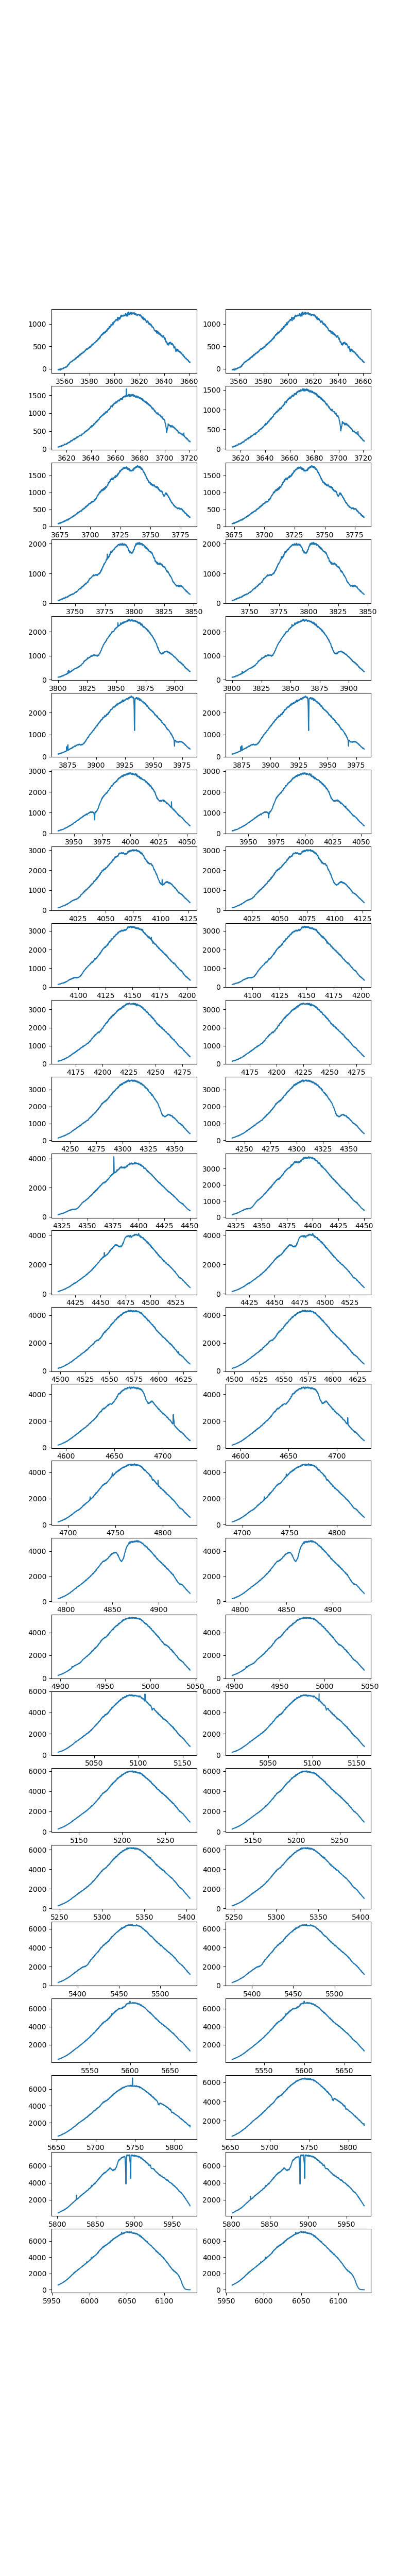

In [373]:
#Para remover los picos se va a tomar 2m+1 puntos alrededor del pico,
#donde m es un entero que definimos nosotros.

orden = list()
spec_norm = list() #lo vamos a usar mas adelante

fig,axs = plt.subplots(len(slice_speclist),2,figsize=(8,50))
for i in range(len(slice_speclist)):
    if(i != 24 and i != 5): #saco los ordenes donde hay interestelares porque las entiende como spikes (para CASLEO)
        m = 5
        f1 = fixer(slice_speclist[i].flux[m:len(slice_speclist[i])-m],m=m,threshold=threshold[i])
        flux_to_norm_1 = ma.append(slice_speclist[i].flux[:m],fixer(f1,m=m,threshold=threshold[i]))
        flux_to_norm = ma.append(flux_to_norm_1,slice_speclist[i].flux[len(slice_speclist[i])-m:])
        axs[i,0].plot(slice_speclist[i].xarr, slice_speclist[i].flux, label = 'original data')
        axs[i,1].plot(slice_speclist[i].xarr, flux_to_norm, label = 'fixed spectrum') 
    elif(i == 24): 
        m=5
        pixel = int(len(slice_speclist[i])/3)
        f1 = fixer(slice_speclist[i].slice(m,pixel,unit='pixel').flux,m=m,threshold=threshold[i])
        flux_to_norm_1 = ma.append(slice_speclist[i].flux[:m],f1)
        flux_to_norm = ma.append(flux_to_norm_1,slice_speclist[i].flux[pixel:])

        
        axs[i,0].plot(slice_speclist[i].xarr[:-1], slice_speclist[i].flux[:-1], label = 'original data') 
        axs[i,1].plot(slice_speclist[i].xarr, flux_to_norm)
    elif(i == 5): 
        m=7
        pixel = int(len(slice_speclist[i])/3)
        f1 = fixer(slice_speclist[i].slice(m,pixel,unit='pixel').flux,m=m,threshold=threshold[i])
        flux_to_norm_1 = ma.append(slice_speclist[i].flux[:m],f1)
        flux_to_norm = ma.append(flux_to_norm_1,slice_speclist[i].flux[pixel:])

               
        axs[i,0].plot(slice_speclist[i].xarr[:-1], slice_speclist[i].flux[:-1], label = 'original data') 
        axs[i,1].plot(slice_speclist[i].xarr, flux_to_norm)      

    # Escribo los ordenes ya limpios como dataframes y los guardo en una lista
    orden.append(pd.DataFrame(zip(np.array(slice_speclist[i].xarr),np.array(flux_to_norm)), columns=['wv','intens']))

## Normalización

### Ajuste de polinomio

Normalizamos ajustando un polinomio de legendre.

Si hay alguna línea muy ancha podemos "enmascararla".

* Hay que ir jugando con el orden del polinomio y el sigma y niter del fiteador que remueve outliers hasta que el continuo quede bien ajustado

In [391]:
mask_data = []

<IPython.core.display.Javascript object>


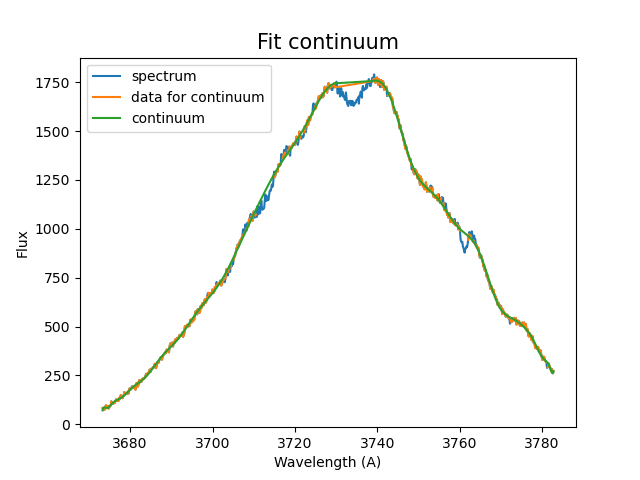

In [427]:
#Los órdenes arrancan en 0!!
or_ech=2

#Enmascaramos una línea (por ahora sólo pude hacerlo funcionar para enmascarar una sola línea)
mask_data = (orden[or_ech]['wv'] > 3716.7) | (orden[or_ech]['wv'] < 3718)

#Modelo inicial, en este caso de legendre (se puede usar también chebyshev)
cont_init = models.Legendre1D(30)

#Definimos el 'fiteador' de los coeficientes del polinomio.
fit = fitting.LinearLSQFitter()

#Definimos el 'fiteador' en conjunto con este que remueve outliers, 
#para que no tenga en cuenta las líneas (o picos que hayan quedado).
# El 'out_fit' puede tener una variable de peso, weights=1.0/flx_clean (o el peso que quieran)
# Yo la saqué porque no lograba que funcione bien así, pero si alguien quiere puede probar
out_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=500, sigma=2.3)

# Ahora ajustamos el polinomio a los datos.
fitted_cont, mask = out_fit(cont_init, orden[or_ech]['wv'][mask_data], orden[or_ech]['intens'][mask_data]) 
filtered_data = np.ma.masked_array(orden[or_ech]['intens'][mask_data], mask=mask)

#Graficamos a ver cómo queda el ajuste
fig5 = plt.figure()
plt.plot(orden[or_ech]['wv'][mask_data], orden[or_ech]['intens'][mask_data], label = 'spectrum')
plt.plot(orden[or_ech]['wv'][mask_data], filtered_data, label = 'data for continuum') 
plt.plot(orden[or_ech]['wv'][mask_data], fitted_cont(orden[or_ech]['wv'][mask_data]), label = 'continuum')
plt.title('Fit continuum',fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Wavelength (A)' ,fontsize = 10)
plt.ylabel('Flux' ,fontsize = 10)
plt.legend()

Escribimos el orden normalizado como un dataframe y los vamos guardando en una lista. Además, graficamos el último orden normalizado para ver cómo queda

<IPython.core.display.Javascript object>


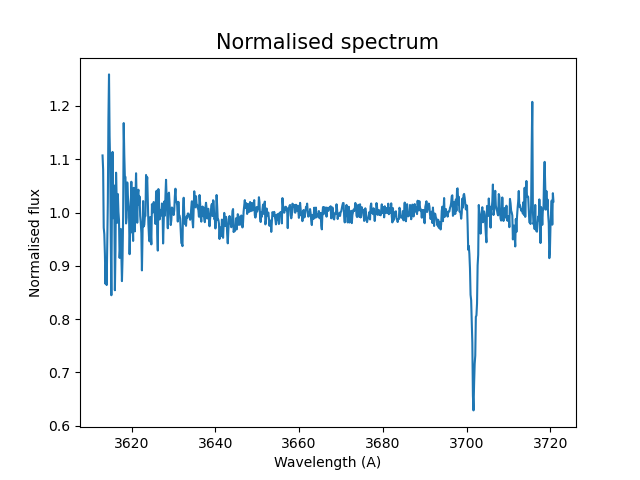

Text(0, 0.5, 'Normalised flux')

In [382]:
#Guardamos el orden normalizado como una entrada en la lista spec_norm
spec_norm.append(pd.DataFrame(zip(np.array(orden[or_ech]['wv']),np.array(orden[or_ech]['intens']/fitted_cont(orden[or_ech]['wv']))), columns=['wv','intens']))

#Graficamos el último orden normalizado
fig6 = plt.figure()
plt.plot(spec_norm[-1]['wv'], spec_norm[-1]['intens']) 
plt.title('Normalised spectrum',fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Wavelength (A)' ,fontsize = 10)
plt.ylabel('Normalised flux' ,fontsize = 10)

### AFS

Para normalizar de esta manera usamos el Alpha-shape Fitting to Spectrum algorithm (Xu,2019) --> __[link del paper](https://iopscience.iop.org/article/10.3847/1538-3881/ab1b47)__

La función del AFS está escrita en R así que haciendo **%R** o **%%R** estamos diciendo que vamos a correr en R esa línea o celda, respectivamente.
Para que eso funcione hay que poner la siguiente celda:

In [ ]:
%load_ext rpy2.ipython

El algoritmo depende de 3 parámetros:
- $\alpha$: es el valor del alpha hull. Por default es 1/6 del rango de la long de onda, según que tan anchas sean las líneas tal vez se encesite que sea mayor o menor. En el paper dicen que el algoritma funciona para valores entre 1/12 y 1/3.
- **q**: el cuartil a tener en cuenta en cada ventana de valores del continuo (ver paper). Se pueden usar valores entre 0.5 y 0.99 según el SNR y la cantidad de líneas de absorción que tenga el orden (Para una absorción como al del paper se usa menor q a menor SNR).
- **m**: el factor de suavizado que se usa cuando se corre la *local polynomial regression*. Para una absorción como la del paper se usan valores entre 0.15 y 0.3.

La lista con todos los órdenes la llevamos a R:

In [ ]:
%R -i orden

Corremos el AFS para cada orden (en R):

In [ ]:
%%R 
source("AFS_v1.R") #alpha=1/4 para que mejoren un poco las líneas de H (default es 1/6)
spec_norm <- c()
for (i in 1:dim(orden)) {
    spec_norm[i] <- list(AFS(orden[i], .9, .35))# AFS(orden,q,m)
}

Volvemos los órdenes originales y los normalizados de vuelta a python para seguir trabajando:

In [ ]:
%R -o spec_norm
%R -o orden

### Visualización + guardado

Graficamos todos los órdenes antes y después de normalizar

<IPython.core.display.Javascript object>


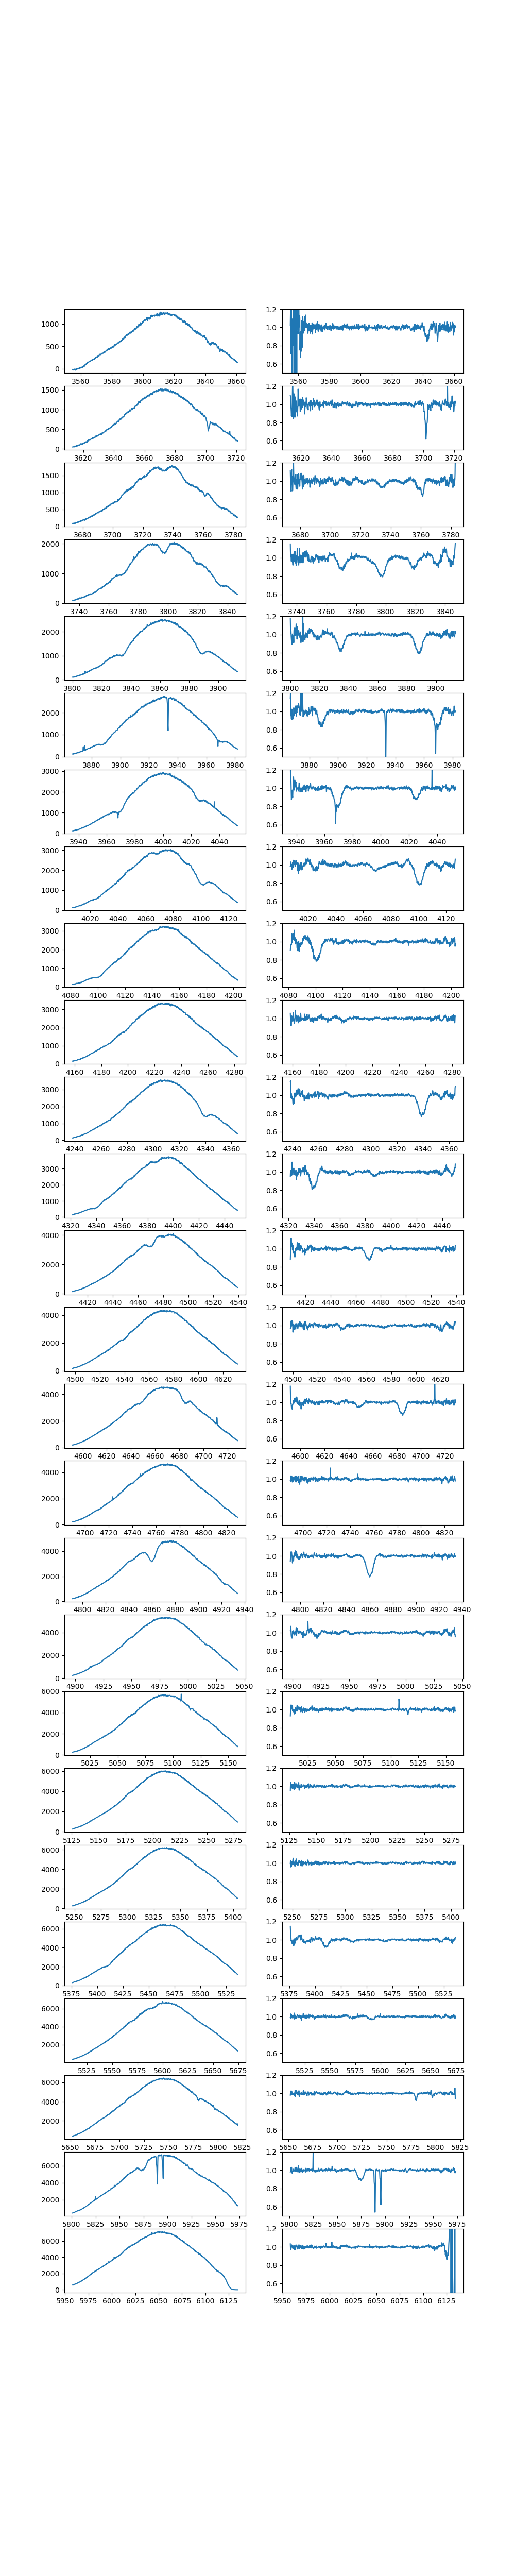

In [356]:
fig,axs = plt.subplots(26,2,figsize=(10,50))

for i in range(len(spec_norm)):
        #sin normalizar
        axs[i,0].plot(orden[i]['wv'],orden[i]['intens'])
        #normalizado
        axs[i,1].plot(spec_norm[i]['wv'],spec_norm[i]['intens'])
        axs[i,1].set_ylim([0.5, 1.2])

* Si queremos podemos guardar los ordenes normalizados, y después leerlos cuando se quiera seguir con la unión

Guardamos los órdenes normalizados

In [357]:
for i in range(len(orden)):
    t = Table.from_pandas(spec_norm[i])
    if (i < 10):
        os.remove('clean0'+str(i)+'_norm.fits')
        t.write('clean0'+str(i)+'_norm.fits')
    else:
        os.remove('clean'+str(i)+'_norm.fits')
        t.write('clean'+str(i)+'_norm.fits')

Leemos los nombres de los fits con los órdenes normalizados y la ordenamos

In [3]:
lista = glob.glob('clean*_norm.fits')
lista.sort()

Armo una lista de dataframes con los órdenes normalizados

In [5]:
# Si armamos los dataframes desde los fits que tienen guardados los órdenes:
orden_norm = list()
for i in range(len(lista)):
    with pf.open(lista[i]) as spec_norm_list:
        orden_norm_data = spec_norm_list[1].data
        orden_norm.append(pd.DataFrame(np.transpose([np.array(orden_norm_data['wv']),np.array(orden_norm_data['intens'])]),columns=['wv','intens']))

# Si lo hacemos directamente después de la normalización, sin guardar:
#orden_norm = list()
#for i in range(len(spec_norm)):
#    orden_norm.append(spec_norm[i])

## Unión de órdenes

### Unión de las long de onda

Definimos la función que une las long de onda

In [49]:
def wave_little_interpol(wavelist):
    '''Make a wavelengths array for merging echelle orders with little interpolation.

    In echelle spectra we often have the situation that neighboring orders overlap
    a little in wavelength space::

        aaaaaaaaaaaa
                 bbbbbbbbbbbbb
                          ccccccccccccc

    When merging those spectra, we want to keep the original wavelength grid where possible.
    This way, we only need to interpolate on a new wavelength grid where different orders
    overlap (here ``ab`` or ``bc``) and can avoid the dangers of flux interpolation in
    those wavelength region where only one order contributes.

    This algorithm has limitations, some are fundamental, some are just due to the 
    implementation and may be removed in future versions:

    - The resulting grid is **not** equally spaced, but the step size should not vary too much.
    - The wavelength arrays need to be sorted in increasing order.
    - There has to be overlap between every order and every order has to have some overlap
      free region in the middle.

    Parameters
    ----------
    wavelist : list of 1-dim ndarrays
        input list of wavelength

    Returns
    -------
    waveout : ndarray
        wavelength array that can be used to co-adding all echelle orders.
    '''
    mins = np.array([min(w) for w in wavelist])
    maxs = np.array([max(w) for w in wavelist])
    
    if np.any(np.argsort(mins) != np.arange(len(wavelist))):
        raise ValueError('List of wavelengths must be sorted in increasing order.')
    if np.any(np.argsort(mins) != np.arange(len(wavelist))):
        raise ValueError('List of wavelengths must be sorted in increasing order.')
    if not np.all(maxs[:-1] > mins[1:]):
        raise ValueError('Not all orders overlap.')
#    if np.any(mins[2:] < maxs[:-2]):
#        raise ValueError('No order can be completely overlapped.')

    waveout = [wavelist[0][wavelist[0]< mins[1]]]
    for i in range(len(wavelist)-1):
        #### overlap region ####
        # No assumptions on how bin edges of different orders match up
        # overlap start and stop are the last and first "clean" points.
        overlap_start = np.max(waveout[-1])
        overlap_end = np.min(wavelist[i+1][wavelist[i+1] > maxs[i]])
        # In overlap region patch in a linear scale with slightly different step.
        dw = overlap_end - overlap_start
        step = 0.5*(np.mean(np.diff(wavelist[i])) + np.mean(np.diff(wavelist[i+1])))
        n_steps = int(dw / step + 0.5)

        wave_overlap = np.linspace(overlap_start + step,  overlap_end - step, n_steps - 1)
        waveout.append(wave_overlap)

        #### next region without overlap ####
        if i < (len(wavelist) -2):  # normal case
            waveout.append(wavelist[i+1][(wavelist[i+1] > maxs[i]) & (wavelist[i+1]< mins[i+2])])
        else:                       # last array - no more overlap behind that
            waveout.append(wavelist[i+1][(wavelist[i+1] > maxs[i])])

    return np.hstack(waveout)

Armamos una lista con las long de onda de cada orden en cada entrada y después llamamos a la función que las va a unir.

Como esa función cambia el paso en las zonas de overlap y nosotros queremos que quede todo con un mismo paso lineal vamos a linealizar el rango de long de onda total (el ya unido)

In [50]:
wave_list = []
for i in range(len(orden_norm)):
    wave_list.append(np.array(orden_norm[i]['wv']))

# Llamamo a la función que une las long de onda
w_unified = wave_little_interpol(wave_list)

# El rango de long de onda final tiene que ser equidistante así que lo linealizamos
w_unified_linear = np.linspace(w_unified[0],w_unified[-1],len(w_unified))

### Unión de los flujos

Vamos a unir los flujos haciendo una suma pero antes vamos a hacer una corrección por bordes a los ordenes para disminuir el ruido allí y que al sumar quede mejor

Antes de corregir por bordes necesitamos que todos los ordenes tengan el mismo paso, así que usamos el paso de las long de ondas unidas y linealizadas

In [88]:
#Paso que vamos a usar
step = w_unified_linear[1]-w_unified_linear[0]

orden_resample = list()
for i in range(len(orden_norm)):
    n = len(orden_norm[i]['wv'])
    #long de onda del orden con el paso deseado
    wvl_resample = (np.arange(start=orden_norm[i]['wv'][0],stop=orden_norm[i]['wv'][n-1],step=step))
    #interpolador para el flujo
    flx_interp   = interpolate.interp1d(orden_norm[i]['wv'],orden_norm[i]['intens'])
    #flujo interpolado para las long de onda con el nuevo paso
    flx_resample = flx_interp(wvl_resample)
    
    #Guardamos los órdenes con el paso en long de onda cambiado
    orden_resample.append(pd.DataFrame(zip(np.array(wvl_resample),np.array(flx_resample)),columns=['wv','intens']))

Ahora definimos la función que va a hacer la boundary correction

In [124]:
def BC(ordenes):
    
    '''Defino la funcion Boundary Correction que estaba implementada en R y la paso a python 
    para que al sumar los órdenes no haya extra ruido debido a los bordes de los órdenes'''
    
    ordenes_corrected = list()
    
    for i in range(1,len(ordenes)-1):
        
        order1 = ordenes[i-1]
        order2 = ordenes[i]
        order3 = ordenes[i+1]
        
        n1 = len(order1)
        n2 = len(order2)
        n3 = len(order3)
        
        #start: start index of the first overlap region in the left order
        #end: the end index of the first overlap region in the middle order
        #start2: start index of the seconda overlap region in the middle order
        #end2: end index of the second overlap region in the right order
        start  = np.where(order1['wv']>=order2['wv'][0])[0][0]
        end    = np.where(order2['wv']>order1['wv'][n1-1])[0][0]
        start2 = np.where(order2['wv']>=order3['wv'][0])[0][0]
        end2   = np.where(order3['wv']>order2['wv'][n2-1])[0][0]

        #temp y temp2 van a guardar las zonas de overlap
        temp  = list()
        temp2 = list()
        
        n_temp  = len(order1['intens'][start:n1])
        n_temp2 = len(order2['intens'][start2:n2])
        
        #Las zonas de overlap las escribimos como la suma pesada de el orden de la izquierda y el de la derecha
        for j in range(n_temp):
            w = j/n_temp
            temp.append((1-w)*order1['intens'][start+j-1] + w*order2['intens'][j])
        for j in range(n_temp2):
            w = j/n_temp2
            temp2.append((1-w)*order2['intens'][start2+j-1] + w*order3['intens'][j])
        
        #Si no hay triple overlap, es decir que el orden del medio no esté completamente contenido entre los otros dos.
        #Esta situación:
        # aaaaaaaaaaaaa
        #       bbbbbbbbbbbbbbbbb
        #                   ccccccccccccc
        if(order1['wv'][n1-1]<order3['wv'][0]):
            if (i-1 == 0):
                #primer orden
                ordenes_corrected.append(pd.DataFrame(zip(np.array(order1['wv']),np.concatenate((order1['intens'][0:(start-1)],temp,1),axis=None)),columns=['wv','intens']))
                #segundo orden
                ordenes_corrected.append(pd.DataFrame(zip(np.array(order2['wv']),np.concatenate((temp,1,order2['intens'][(end+1):(start2-1)],temp2,1),axis=None)),columns=['wv','intens']))
            elif (i+1 == len(ordenes)-1):
                #anteúltimo orden
                ordenes_corrected.append(pd.DataFrame(zip(np.array(order2['wv']),np.concatenate((temp,1,order2['intens'][(end+1):(start2-1)],temp2,1),axis=None)),columns=['wv','intens']))
                #último orden
                ordenes_corrected.append(pd.DataFrame(zip(np.array(order3['wv']),np.concatenate((temp2,1,order3['intens'][(end2+1):n3]),axis=None)),columns=['wv','intens']))
            else:
                #ordenes del medio
                ordenes_corrected.append(pd.DataFrame(zip(np.array(order2['wv']),np.concatenate((temp,1,order2['intens'][(end+1):(start2-1)],temp2,1),axis=None)),columns=['wv','intens']))
        
        #Si hay triple overlap, es decir esta situación:
        # aaaaaaaaaaa
        #      bbbbbbbbbb
        #         cccccccccc
        else:
            #En este caso buscamos un tercer overlap entre temp y temp2
            #que guardan las zonas de overlap entre el orden de la izquierda y el del medio (temp)
            # y entre el orden del medio y el de la derecha (temp2)
            start3  = np.where(temp>=temp2[0])[0][0]
            end3    = np.where(temp2>temp[n_temp-1])[0][0]
            
            temp3 = list()
            
            n_temp3 = len(temp[start3:n_temp])
            
            for j in range(n_temp3):
                temp3[j].append((temp[start3+j-1] + temp2[j]) / 2.)
                
            if (i-1 == 0):
                #primer orden
                ordenes_corrected.append(pd.DataFrame(zip(np.array(order1['wv']),np.concatenate((order1['intens'][0:(start-1)],temp,1),axis=None)),columns=['wv','intens']))
                #segundo orden
                ordenes_corrected.append(pd.DataFrame(zip(np.array(order2['wv']),np.concatenate((temp[0:(start3-1)],temp3,temp2[(end3+1):n_temp2]),axis=None)),columns=['wv','intens']))
            elif (i+1 == len(ordenes)-1):
                #anteúltimo orden
                ordenes_corrected.append(pd.DataFrame(zip(np.array(order2['wv']),np.concatenate((temp,order2['intens'][(end+1):(start2-1)],temp2),axis=None)),columns=['wv','intens']))
                #último orden
                ordenes_corrected.append(pd.DataFrame(zip(np.array(order3['wv']),np.concatenate((temp2,order3['intens'][(end2+1):n3]),axis=None)),columns=['wv','intens']))
            else:
                #ordenes del medio
                ordenes_corrected.append(pd.DataFrame(zip(np.array(order2['wv']),np.concatenate((temp[0:(start3-1)],temp3,temp2[(end3+1):n_temp2]),axis=None)),columns=['wv','intens']))
            
    return(ordenes_corrected)

Llamamos a la función que hace la corrección de bordes

In [127]:
corrected = list()
corrected = BC(orden_resample)

Graficamos los órdenes antes y después de la corrección de los bordes para comparar

<IPython.core.display.Javascript object>


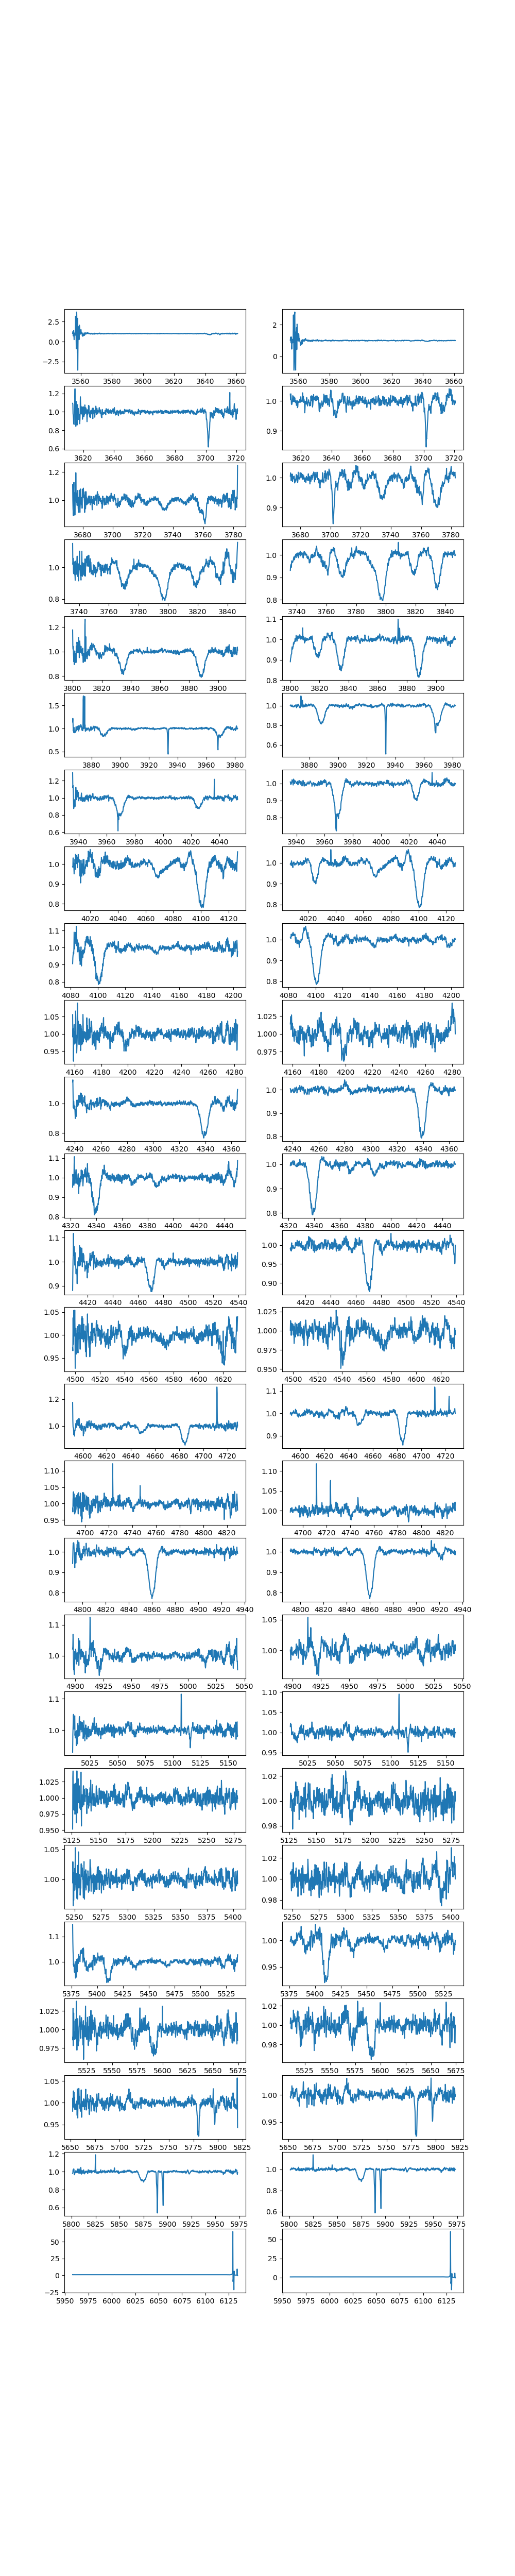

In [112]:
fig,axs = plt.subplots(26,2,figsize=(10,50))
for i in range(len(corrected)):
        #sin corregir
        axs[i,0].plot(orden_norm[i]['wv'],orden_norm[i]['intens'])
        #corregido
        axs[i,1].plot(corrected[i]['wv'],corrected[i]['intens'])

Los órdenes están guardados en una lista de dataframes y los paso a objetos Spectrum1D porque voy a usar un método de resample para este tipo de objetos

In [128]:
speclist_BC = list()
for i in range(len(corrected)):
    speclist_BC.append(Spectrum1D(spectral_axis=np.array(corrected[i]['wv'])*u.AA,flux=np.array(corrected[i]['intens'])*u.dimensionless_unscaled))

Para poder sumar los flujos directamente tenemos que interpolarlos al rango de long de onda ya unido (*w_unified_linear*), donde en la zona del orden va a guardar su flujo y en el resto del rango rellena con 0

In [135]:
#interpolador lineal
resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')

resample_spec = list()
#Hacemos el resample de los órdenes para el nuevo array de long de onda
for i in range(len(speclist_BC)):
    resample_spec.append(resampler.resample1d(speclist_BC[i],w_unified_linear*u.AA))

#Después de hacer el resample sumo todos los ordenes
sum_spec = np.sum(resample_spec)

Al sumar los flujos, las partes donde hay overlap van a estar en 2 y no en 1, entonces en esas partes tengo que volver el flujo a 1. Para eso hago lo siguiente:
- Elijo un orden donde no haya (o haya muy pocas) líneas y calculo la media/mediana y stdv, que van a ser representativos del continuo. Lo hago con un sigma clip para no tener en cuenta puntos que se alejen una cantidad x de sigma.

In [130]:
order_no_lines = 19 #elijo el orden 19 porque es uno de los que no tienen lineas. Va a cambiar para cada espectro
mean_cont, median_cont, stdv_cont = sigma_clipped_stats(speclist_BC[order_no_lines].flux, sigma=3, maxiters=10)

- Ahora, uso la media y stdv estimada del continuo para identificar las zonas donde el flujo no está en 1, y reescribo el flujo

In [138]:
for i in range(len(sum_spec.flux)):
    if (abs(sum_spec.flux[i]) > mean_cont+5*stdv_cont):
        sum_spec.flux[i] = sum_spec.flux[i] - 1.
    else:
        sum_spec.flux[i] = sum_spec.flux[i]

- Limpio el espectro de picos grandes que hayan quedado: grafico la mediana del espectro entero y x*sigma para eliminar los picos no reales.

<IPython.core.display.Javascript object>


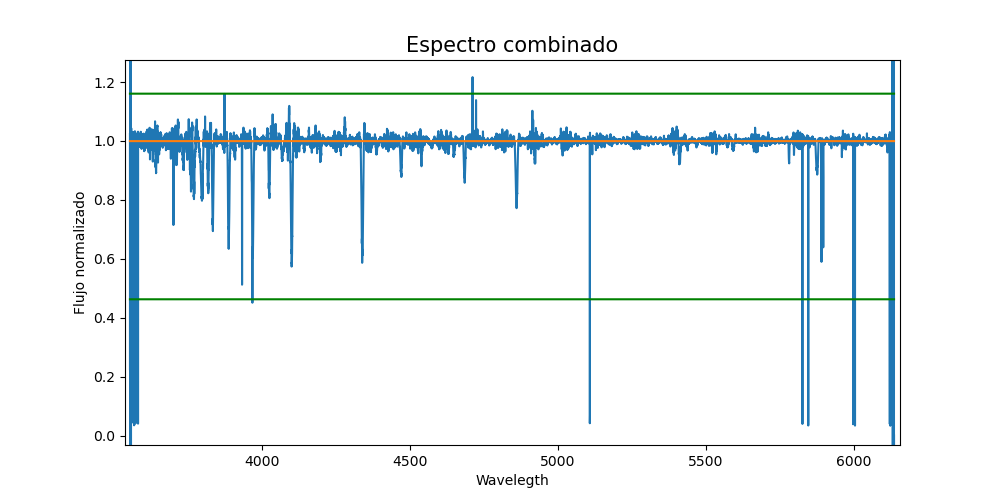

Text(0, 0.5, 'Flujo normalizado')

In [140]:
fig = plt.figure(figsize=(10,5))

# Espectro combinado
plt.plot(sum_spec.spectral_axis,sum_spec.flux)
#Grafico la mediana del espectro entero
plt.plot(sum_spec.spectral_axis,np.ones_like(sum_spec.flux)*np.median(sum_spec.flux))
#Grafico x*sigma desde la mediana. Hay que probar que x
plt.plot(sum_spec.spectral_axis,np.ones_like(sum_spec.flux)*(np.median(sum_spec.flux)+0.3*sum_spec.flux.std()),'-g')
plt.plot(sum_spec.spectral_axis,np.ones_like(sum_spec.flux)*(np.median(sum_spec.flux)-1*sum_spec.flux.std()),'-g')

plt.title('Espectro combinado',fontsize = 15)
plt.xlabel("Wavelegth",fontsize = 10)
plt.ylabel("Flujo normalizado",fontsize = 10)

- Los puntos que se alejan más de x*sigma los vuelvo al continuo (se puede hacer algo más sofisticado como hacer un promedio de los puntos de alrededor, pero por ahora lo dejo así)

In [141]:
for i in range(len(sum_spec.flux)):
    if ((abs(sum_spec.flux[i]) > (np.median(sum_spec.flux)+0.3*sum_spec.flux.std())) or (abs(sum_spec.flux[i]) < (np.median(sum_spec.flux)-1*sum_spec.flux.std()))):
        sum_spec.flux[i] = 1.

Grafico para ver que haya quedado bien

<IPython.core.display.Javascript object>


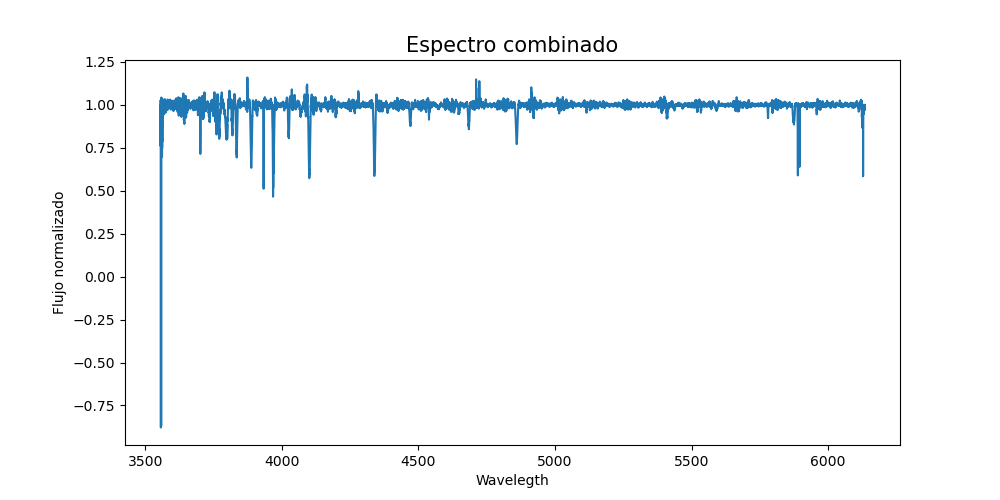

Text(0, 0.5, 'Flujo normalizado')

In [142]:
fig = plt.figure(figsize=(10,5))
plt.plot(sum_spec_BC.spectral_axis,sum_spec.flux)
plt.title('Espectro combinado',fontsize = 15)
plt.xlabel("Wavelegth",fontsize = 10)
plt.ylabel("Flujo normalizado",fontsize = 10)

## Save

Agrego al header una keyword de la unión de los órdenes y elimino espacios en blanco del header

In [145]:
hdu = speclist[0].header #Agarro el header del primer orden pero podría ser cualquiera
hdu.append(('MERGED','yes', 'Merged and clean spectrum (python)'), end=True)
hdu.remove("",remove_all=True)
hdu.remove("COMMENT",remove_all=True)

* Hay que agregar algunos keywords para que IRAF entienda el espectro 
* Necesitamos los numeritos de los límites de extracción de la apertura para poner en el nuevo keyword 'APNUM1', que están en el keyword 'WAT2_002'

In [146]:
hdu

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
ORIGIN  = 'NOAO-IRAF FITS Image Kernel December 2001' / FITS file originator    
DATE    = '2006-05-13T19:00:02'                                                 
IRAF-TLM= '21:42:09 (12/05/2007)'                                               
OBJECT  = 'HD165246'           / Name of the object observed                    
OBSERVAT= 'CASLEO             '  / observatory                                  
DATE-OBS= '2006-05-13         '  / date (yyyy-mm-dd) of obs.                    
UT      = '06:41:35'           / universal time                                 
ST      = '17:34:28'           / sidereal time                                  
HA      = '-00:32:04'          / hour angle                                     
RA      = '18:06:32'        

* Creamos un objeto *hdulist* para poder guardar el espectro en fits y que iraf después lo pueda leer

In [147]:
hdu2 = pf.PrimaryHDU(np.array(sum_spec.flux)) # flux 
hdu2.header = hdu #header

wvl = np.array(sum_spec.spectral_axis)   

# Header keywords relevant for wavelength axis
hk = {}
hk["CTYPE1"] = "Linear"
hk["CRPIX1"] = 1
hk["CRVAL1"] = wvl[0]
hk["CDELT1"] = float(wvl[-1] - wvl[0]) / (len(wvl)-1)
hk["CD1_1"] = float(wvl[-1] - wvl[0]) / (len(wvl)-1)
hk["WAT0_001"] = 'system=equispec'
hk["WAT1_001"] = 'wtype=linear label=Wavelength units=angstroms'
hk["NCOMBINE"] = 26 #Este numero es para echelles del CASLEO
hk["DC-FLAG"] = 0 #0 lineal, 1 logaritmo
hk["APNUM1"] = '1 62 19.35 28.09' # ap, nro de beam, límites de extracción de la apertura

for k in hk.keys():
    hdu2.header[k] = hk[k]
    
hdulist = pf.HDUList([hdu2])
hdulist.writeto('test_0605CAS.fits',overwrite=True)